#MISSION : Analyse des ventes d'une grande chaîne de librairie

Avec les données mises à disposition par le service informatique, la première mission du data analyst sera de faire une analyse et une présentation des données à l'aide de statistqiues descriptives. \\

ps :La chaîne de librairie s'est d'abord développée dans une grande ville de France, avec plusieurs magasins, jusqu'à décider d'ouvrir une boutique en ligne. Son approche de la vente de livres en ligne, basée sur des algorithmes de recommandation, lui a valu un franc succès !


#Les données 


In [93]:
"relancez cette cellule quand vous voulez repartir de zéro"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns 
from IPython.display import display
import seaborn; seaborn.set()
plt.style.use('seaborn')
np.set_printoptions(precision=2,linewidth=500,suppress=True)

> Inportation des données

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
customers=pd.read_csv('/content/drive/MyDrive/dataset_P4/customers.csv')
products=pd.read_csv('/content/drive/MyDrive/dataset_P4/products.csv')
transactions=pd.read_csv('/content/drive/MyDrive/dataset_P4/transactions.csv',parse_dates=[1])

> Une fois les données importées, on affiche chacune des tables obtenues pour pour avoir une idée de leur composition.

In [96]:
#Les clients
display(customers.head(3))
print("\n")
#Les produits
display(products.head(3))
print("\n")
#Les transactions
display(transactions.head(2))

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984


,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0


,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277


On remarque que dans la table _*transactions*_ la colonne date censée 
contenir que les dates de transcation de chaque client contient en effet pour chaque client la date et *l'heure de la transaction*. Cette colonne est en fait sous format date-heure. Pour rendre les choses un peu plus clair, nous allons  créer une nouvelle colonne qui va s'appeler ***date_only*** contenant que les dates (et non pas l'heure) de transaction de chaque client.


Mais lorsque l'on tente de convertir la colonne *date* en format *datetime* on reçoit un message d'erreur qui nous signale que certaines dates de la colonne *date* ne sont pas au bon format. Après investigation, on remarque que qu'il existe des colonnes dont la date commence pas : *test_2021* . Nous allons maitenant repérer les lignes dont la date commence par *test*

In [97]:
transactions[transactions['date'].str.contains('test')].head(2)

,id_prod,date,session_id,client_id
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1


On remarque que dans notre tableau il y a 200 lignes où la date commence par *test_..*

In [98]:
print(set(transactions[transactions['date'].str.contains('test')].client_id))
print(set(transactions[transactions['date'].str.contains('test')].session_id))
print(set(transactions[transactions['date'].str.contains('test')].id_prod))

{'ct_1', 'ct_0'}
{'s_0'}
{'T_0'}


Les clients concernés par ces dates commençant par les dates commençant par *test_* sont seulement les clients *ct_0* et *ct_1*. Ces clients ont commandés le produit *T_0* à la session *s_0*. Tout cela nous amène à considérer que les client *ct_0* et *ct_1* ne sont pas des clients réels. En réalité ce sont de clients test, et donc leur transcations ne sont aussi que des tests. D'ailleurs on remarque aussi que les transactions de ces deux clients sont effectuées à la mêmme et heure à quelques microseconde près. Ce qui conforte notre considération.

On va dans la suite de l'étude supprimer de notre base de données les clients *ct_0*, *ct_1*, le produit *T_0* de notre table en les considérants comme données aberrantes.

####Quelques fonctions pour nettoyer les données

In [99]:
#Pour vérifier si il y a des doublons
def check_doublon(df, col):
  for i in range(len(df[col].duplicated())):
    if df[col].duplicated()[i] == True:
      return True

import re
def format_compat(valeur):
  bool=True
  i=re.search("s_\d",valeur)
  if i is None:
    bool=False
  return bool

# Mission



---


## Mision n°1 : 
Avant de pouvoir entrer dans le vif du sujet, il vous faudra faire un peu de nettoyage !  Par exemple, vous devrez faire des choix quant au traitement des **valeurs manquantes** et des **valeurs aberrantes**.



---



# <center>  <ins> 1. Nettoyage des données </ins> <center> 
<center> <ins> nettoyage chaque table </center> </ins>

1. <ins>On vérifie si il y a des valeurs manquantes dans nos tables.</ins>

In [100]:
print(customers.isnull().sum(),"\n")
print(products.isnull().sum(),"\n" )
print(transactions.isnull().sum(),"\n")

client_id    0
sex          0
birth        0
dtype: int64 

id_prod    0
price      0
categ      0
dtype: int64 

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64 



Il n'y a pas de valeurs manquantes au dans nos tables.

2. <ins>Vérification des valeurs aberrantes</ins>
 > On avait détecté la présence de données aberantes dans la table *transactions*. Les clients concernés par ces données sont *ct_0* et *ct_1*, le produit concerné est le produit *T_0*. Il nous faudra donc supprimé ces clients dans toutes nos tables.

In [101]:
customers=customers.drop(customers[(customers['client_id']=='ct_0') | (customers['client_id']=='ct_1')].index) # TABLE CLIENTS
products=products.drop(products[(products['id_prod']=='T_0') | (products['id_prod']=='T_0')].index)           # TABLE PRODUITS
transactions=transactions.drop(transactions[(transactions['client_id']=='ct_0') | (transactions['client_id']=='ct_1')].index)  # TABLE TRANSACTIONS

In [102]:
#On vérifie d'abord si il n'y pas de doublons puis on suprrime les clients ct_0 et ct_1
print(customers.pivot_table(index = ['client_id'], aggfunc ='size').sum()-len(customers.client_id.unique()))
print(products.pivot_table(index = ['id_prod'], aggfunc ='size').sum()-len(products.id_prod.unique()))

0
0


Créations deux nouvelles tables : une première qui contient que les clients qui ont fait une commande durant la période, une deuxième contenant que les produits commandées durant la période.

# <center> <ins> 2. Création de la base de données complète des transactions </ins> </center>
On fait dans un premier temps une jointure des tables cust(clients) et trans(transactions), puis on joint la table obtenue à la table prod (produits). Cela nous permettra d'avoir une base de données complète des clients de leurs transactions.

1. <ins>Construction de la base de données 

In [103]:
first_joint=pd.merge(customers,transactions, how='inner', on='client_id')

In [104]:
base_données=pd.merge(first_joint,products, how='inner', on ='id_prod')

 Nous allons rajouter une colonne age contenant l'âge de chaque client. Et d'une colonne qte_prod contenant le quantité de produits commandées par chaque client.

In [105]:
base_données['age']=2022-base_données['birth']
base_données['qte_prod']=1

In [106]:
#On garde une copie de notre base de données
base_données_arch =base_données.copy()

2. <ins>Vérification des types de chaque colonne et correction</ins>

In [107]:
base_données.dtypes

client_id      object
sex            object
birth           int64
id_prod        object
date           object
session_id     object
price         float64
categ           int64
age             int64
qte_prod        int64
dtype: object

In [108]:
base_données["date"]=pd.to_datetime(base_données["date"])

Notre table finale, c'est à dire celle que l'on va utiliser pour les analyse est maitenant complète. Elle s'appelle <ins>base_données</ins> : elle contient l'identifiant du client, son âge, son sexe, l'indentifiant du prix commandés, la date de transaction, le produit commandé etc. 

# <center><ins> STATISTIQUES DESCRIPTIVES</center></ins>

## 1. Mesure de la concentration : client vs nombre de produits achetés

Nous allons créer une table contenant : client, son âge, son sexe et le nombre de produits commandés

In [109]:
c_1=base_données[['client_id','qte_prod']].groupby(by=['client_id']).sum().reset_index()
c_2=base_données[['client_id','age','sex']].groupby('client_id').first().reset_index()
cust_nb_cm=pd.merge(c_1,c_2, how='inner',on='client_id')   # Jointure des deux tables

In [110]:
cust_nb_cm.head()

,client_id,qte_prod,age,sex
0,c_1,20,67,m
1,c_10,28,66,m
2,c_100,6,30,m
3,c_1000,56,56,f
4,c_1001,58,40,m


In [111]:
cust_nb_cm.quantile(0.95)

qte_prod    114.0
age          73.0
Name: 0.95, dtype: float64

## <center>Conclusion</center>
---
1. On voit d'après le tableau obtenu qu'il y a des clients qui ont fait 1 commande, d'autres une dizaine et certains une centaine. Seuls 4 clients ont fait plus de 2000 commandes durant cette période. Et parmi ces 4 clients un seul a effectué 12855 commandes. 
---
2. On note aussi que 95% des clients on fait moins 114 commandes et 75% d'entre eux ont fait moins 47 commandes. D'après les observations que nous venons de faire il serait utile de ranger les clients dans une des catégories suivantes : 'client_moyen', 'petit_revendeur' et 'gros_revendeur'.
---

> ## 2.COURBE DE LORENZ : clients vs nombre de produits achetés

> #### CODE

Dans cette table les clients sont classés par groupe.Deux clients appartienent au même groupe si ils ont fait le même nombre de commandes durant la période considérée. Ainsi on voit bien dans notre tableau qu'il y a 36 clients qui ont une seule commandes et 1 seul clients qui a fait 12855 commandes. Donc on dira que 36 clients sont dans le premier groupe et 1 client est dans le dernier groupe.

In [112]:
nb_com_per_group=cust_nb_cm.groupby(by='qte_prod').size()
nb_com_per_group=pd.DataFrame({'nb_com':nb_com_per_group.index, 'nb_client':nb_com_per_group.values})

Nous alons calculer les fréquences cumulées croissantes de <ins>*nb_com*</ins> et <ins>*nb_client*</ins> de notre table.

In [113]:
#Fréquence cumulées croissantes nombre des commandes
nb_com_per_group['freq_com_CC'] =((nb_com_per_group['nb_com']*nb_com_per_group['nb_client']))/((nb_com_per_group['nb_com']*nb_com_per_group['nb_client']).sum())
nb_com_per_group['freq_com_CC']=nb_com_per_group['freq_com_CC'].cumsum()*100

#Fréquence cumulées croissantes nombre des client
nb_com_per_group['freq_client_CC'] =(nb_com_per_group['nb_client']/nb_com_per_group['nb_client'].sum()).cumsum()*100

> #### courbe

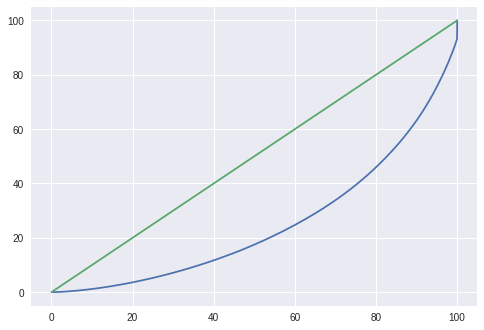

In [114]:
plt.plot(nb_com_per_group.freq_client_CC,nb_com_per_group.freq_com_CC)
plt.plot([0,100],[0,100])

On remarque 40% des produits sont achetés par 10% des clients (gros acheteurs, revendeurs). Et que 20% des clients (petits acheteurs) ont achetés environ 5% des produits.

## <center> Conclusion</center> 
---
1. La courbe de Lorentz nous montre que 50% des produits sont achetés par 15% des clients. Ces 15% sont potentiellement des revendeurs. Donc pour avoir une idée plus précise sur le profil de nos clients. Il faudra exclure les revendeurs de l'enchantillon.
---
2. Pour ce faire nous allons dans un premier temps compléter notre base de données en y incluant une colonne *nb_total_prod_cm* contenant le nombre total de produits commandés par chaque client, et dans un deuxième temps nous allons exclure les gros vendeurs.
---

1. > <ins>complétion de la base de données

In [115]:
base_données=pd.merge(base_données,cust_nb_cm[['client_id','qte_prod']], how='inner',on='client_id').copy()
base_données.rename(columns={'qte_prod_y':'nb_total_prod_cm'}, inplace=True)
base_données.rename(columns={'qte_prod_x':'qte_prod'}, inplace=True)

In [116]:
base_données.head()

,client_id,sex,birth,id_prod,date,session_id,price,categ,age,qte_prod,nb_total_prod_cm
0,c_4410,f,1967,0_1455,2021-03-22 14:29:25.189266,s_9942,8.99,0,55,1,36
1,c_4410,f,1967,0_1376,2021-09-24 22:58:27.418343,s_94984,16.24,0,55,1,36
2,c_4410,f,1967,1_312,2022-01-29 14:07:47.482092,s_156960,24.56,1,55,1,36
3,c_4410,f,1967,1_653,2021-07-29 23:34:41.866951,s_68860,25.99,1,55,1,36
4,c_4410,f,1967,0_1110,2021-11-04 16:28:30.169021,s_114715,4.71,0,55,1,36


2. > <ins>On exclu les gros vendeurs de la base de données

En excluant les 15%, il nous restera 85% des clients. C'est à dire ceux qui ont fait moins 67 commandes. Notre nouvelle table *clients_lambda* contient que les  commandes des clients ayant fait moins de 67 commandes.

In [117]:
seuil=cust_nb_cm.quantile(0.85)[0]
clients_lambda=base_données[base_données.nb_total_prod_cm<=seuil]
clients_lambda

,client_id,sex,birth,id_prod,date,session_id,price,categ,age,qte_prod,nb_total_prod_cm
0,c_4410,f,1967,0_1455,2021-03-22 14:29:25.189266,s_9942,8.99,0,55,1,36
1,c_4410,f,1967,0_1376,2021-09-24 22:58:27.418343,s_94984,16.24,0,55,1,36
2,c_4410,f,1967,1_312,2022-01-29 14:07:47.482092,s_156960,24.56,1,55,1,36
3,c_4410,f,1967,1_653,2021-07-29 23:34:41.866951,s_68860,25.99,1,55,1,36
4,c_4410,f,1967,0_1110,2021-11-04 16:28:30.169021,s_114715,4.71,0,55,1,36
...,...,...,...,...,...,...,...,...,...,...,...
336708,c_1675,f,2000,0_2134,2021-06-17 13:03:04.694904,s_49879,5.57,0,22,1,1
336709,c_1232,f,1960,0_142,2021-09-25 18:07:25.880052,s_95415,19.85,0,62,1,1
336710,c_4391,f,2001,2_147,2021-07-23 07:01:38.963669,s_65994,181.99,2,21,1,1
336711,c_4540,m,2003,2_147,2021-12-05 00:31:15.530765,s_129519,181.99,2,19,1,1


## <ins> Sur les clients </ins> 


 on crée d'abord une table cust_achat que l'on extrait de la table *client_lambda* qui contient toutes les infos pertinentes pour analyser nos clients, à savoir : l'âge du client, son sexe, et le nombre de produit commandé.

In [118]:
tab=clients_lambda[['client_id','sex']].groupby('client_id').first().reset_index()

In [119]:
tab.sex.value_counts(normalize=True)*100

f    52.077638
m    47.922362
Name: sex, dtype: float64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


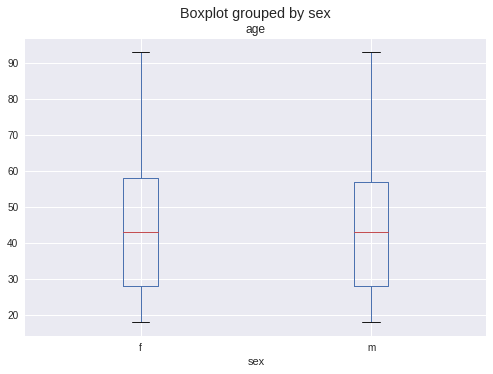

In [120]:
tab=clients_lambda[['client_id','age','sex','nb_total_prod_cm']].groupby('client_id').first().reset_index()
tab.boxplot(by='sex', column=['age'])

Il y a 52.07% de femmes dans notre echantillon et 48% d'hommes.  D'après les boxplots obtenus on voit la distribution des âges chez les femmes est identique à celle des hommes.

In [121]:
p_cent=clients_lambda[['sex','nb_total_prod_cm']].groupby('sex').sum().reset_index().nb_total_prod_cm
print('les femmes acheté',round(p_cent[0]/p_cent.sum()*100,2),'% des produits')
print('les hommes ont acheté',round(p_cent[1]/p_cent.sum()*100,2),'% des produits')

les femmes acheté 52.26 % des produits
les hommes ont acheté 47.74 % des produits


- les femmes acheté 52.26 % des produits
- les hommes ont acheté 47.74 % des produits

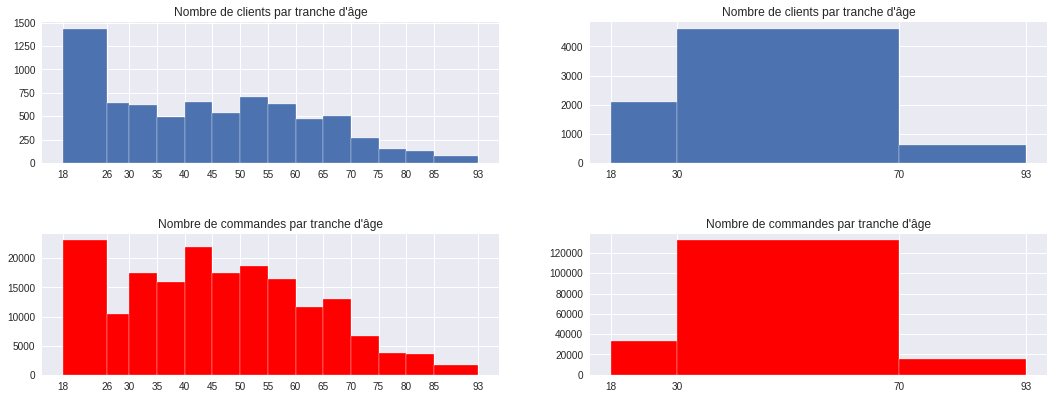

In [122]:
plage=[18, 26, 30, 35, 40, 45, 50 ,55, 60 ,65, 70, 75, 80, 85, 93]
plage1=[18, 30, 70 , 93]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 5))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.2)

ax[0,0].hist(tab.age, bins=plage)
ax[0,0].set_xticks(plage)
ax[0,0].set_title("Nombre de clients par tranche d'âge")

ax[0,1].hist(tab.age, bins=plage1)
ax[0,1].set_xticks(plage1)
ax[0,1].set_title("Nombre de clients par tranche d'âge")

ax[1,0].hist(tab.age, weights=tab.nb_total_prod_cm,color='red', bins=plage)
ax[1,0].set_xticks(plage)
ax[1,0].set_title("Nombre de commandes par tranche d'âge")

ax[1,1].hist(tab.age, weights=tab.nb_total_prod_cm,color='red', bins=plage1)
ax[1,1].set_xticks(plage1)
ax[1,1].set_title("Nombre de commandes par tranche d'âge")

plt.show()

- On voit bien que la tranche d'âge qui achète la plupart des produits se situent entre 30 et 60 ans.
- l'âge moyen de 44 ans avec un ecart-type de 18. l'âge médian est de 43 proche de l'âge moyen. Par contre l'âge le plus fréquent est 18 ans. Les clients âgés de 18 ans totalisent environ 32% achats parmi les 18-25 ans et 20% des ventes parmi les 18-30 ans. 
- On voit aussi que le nombre de commandes des tranches d'âge située entre 30 et 60 ans est assez proche. De plus les clients situés dans cette tranche d'âge totalisent la majorité des commandes.

In [123]:
print('le mode est :',tab.age.mode()[0], '\n')
display(tab.age.describe()[1:5])

le mode est : 18 



mean    43.989338
std     17.980764
min     18.000000
25%     28.000000
Name: age, dtype: float64

## <center> Conclusion </center>
---
1. Il y a 52.07% de femmes dans notre echantillon et 48% d'hommes.  D'après les boxplots obtenus on voit la distribution des âges chez les femmes est identique à celle des hommes.
---
2. On voit que la moyenne d'âge est de 44 ans avec un ecart-type de 13. L'âge médian est de 42 ans et le mode est égal à 42. Donc on remarque que la médiane est égale au mode et que il n'y a pas un très grand écart entre la moyenne, la médiane et le mode. On peut dire que notre distribution des âges présente une lègère symétrie avec un lègère oblicité à gauche. Puisque 57% des âges sont inférieurs à la moyenne tadis qui 43% sont supérieurs à la moyenne.
Notons que dans notre echantillon la moyenne n'a pas été sensible aux valeurs extrêmes.
---
3. D'après le graphique sur le nombre de commandes par tranches d'âge on voit que l'on regouper les clients en 3 groupes : le groupe des 18-29 ans, celui des 30-69 ans, et celui des 69-93 ans. Le groupe des 30-69 ans totamise la majorité des achats.
---

## <ins> Sur les produits </ins>


 on crée d'abord une table prod_achat que l'on extrait de la table *client_lambda* qui contient toutes les infos pertinentes pour analyser nos produits, à savoir : l'âge du client, son sexe, et le nombre de produit commandé.

In [124]:
prod_achat=clients_lambda.groupby(['id_prod', 'price','categ'])['qte_prod'].agg('sum').reset_index()

On remarque il y a 3 catégories de produits aux prix différents.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


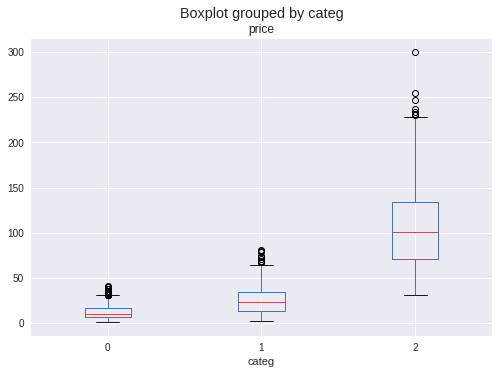

In [125]:
prod_achat.boxplot(by='categ', column=['price'])

Nombre de produits vendus par catégorie.

In [126]:
base_données.categ.value_counts()/base_données.categ.value_counts().sum()*100

0    62.197183
1    32.590069
2     5.212748
Name: categ, dtype: float64

Chiffre d'affaires en % par catégorie de produit

In [127]:
base_données.groupby('categ').sum().price/base_données.groupby('categ').sum().price.sum()*100

categ
0    38.466191
1    38.770883
2    22.762926
Name: price, dtype: float64

## <center> Conclusion </center>
---
1. 62.2% des produits vendus sont de catégorie 0 ; 32.6 % sont de catégorie 1 et 5.2% sont de catégorie 2. \\
On voit que les produits de la catégorie 0 sont moins chèrs que ceux de la catégorie 1 qui sont moins chèrs que ceux de la catégorie 3.      
  Dans l'ensemble il n'y a pas de très gros écarts de prix entre produit de 
même catégorie.

---
2. 
- Le prix moyen des produits de catégorie 0 est de 11.69 et un ecart-type de 7.35. Le prix médian des produits de catégorie 0 est de 10.3. 

- Le prix moyen des produits de catégorie 1 est de 25.5 et un ecart-type de 15.4.35. Le prix médian des produits de catégorie 1 est de 22.99. 

- Le prix moyen des produits de catégorie 2 est de 107.48 et un ecart-type de 49.3. Le prix médian des produits de catégorie 2 est de 100.99.

---

3. En termes de chiffre d'affaire la vente des produits de catégories 0 représente 38.5%, et celle de sproduits de catégories 1 et 2 représentent respcetivement 38.8% et 22.76%
---

## Les transactions

In [128]:
base_données['date_jma']=pd.to_datetime(base_données['date'].dt.date)
time_series=base_données.copy()

On trace le graphique série temporelles des ventes

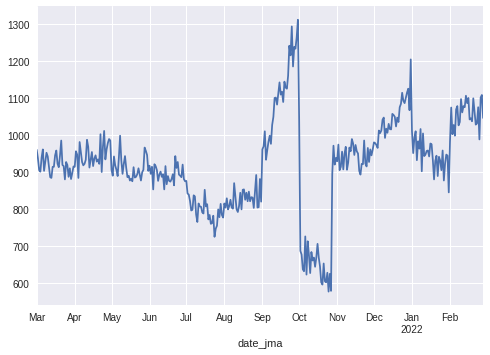

In [129]:
time_series.groupby('date_jma')['qte_prod'].agg('sum').plot()

On remarqu'il y a une baisse subite des ventes au mois d'octobre. Pour connaître la raison de cette baisse, il nous faut en premier lieu vérifier si cette baisse concerne toutes les catégories de produits ou pas.

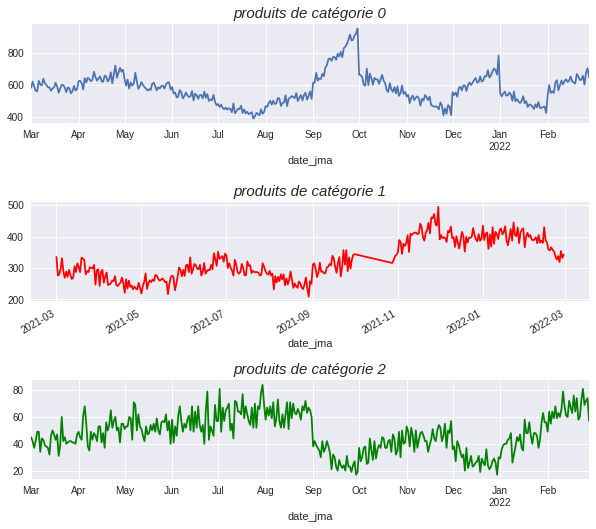

In [130]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)

ax1.set_title ('produits de catégorie 0', fontstyle='italic', fontsize=15)
ax2.set_title ('produits de catégorie 1',fontstyle='italic',fontsize=15)
ax3.set_title ('produits de catégorie 2',fontstyle='italic',fontsize=15)


time_series[time_series.categ.isin([0.])].groupby('date_jma').sum().qte_prod.plot(ax=ax1)
time_series[time_series.categ.isin([1.])].groupby('date_jma').sum().qte_prod.plot(color='red',ax=ax2)
time_series[time_series.categ.isin([2.])].groupby('date_jma').sum().qte_prod.plot(color='green',ax=ax3)
plt.show()

## <center> Conclusion </center>
---
<center> On voit que la baisse des ventes en octobre concerne dans une très large mesure les produits de catégorie 0 et dans une très moindre mesure les produits de catégorie 1. </center>

--- 

#MISSION 3

##1.Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés?

## <center> Tableau de contingence et corrélation </center>

J'établi le tableau de contingence puis, je mets des index entiers pour pouvoir effectuer plus facilement des calculs matriciels.  l'index 0 correspond à "femme" ,l'index 1 correspond à "homme" et l'index 2 correspond à total.

In [131]:
tab_cont=pd.crosstab(clients_lambda.sex, clients_lambda.categ, margins=True)
tab_cont.reset_index(drop=True,inplace=True)

Je calcule la fréquence d'hommes et de femmes dans l'enchatillon.

In [132]:
tab_cont['freq']=tab_cont.All/tab_cont.All[2]

Je calcule l'effectif de femmes et d'hommes "espérées" pour chaque catégorie.

In [133]:
eff_attendu = np.array([ [ tab_cont[0][2]*tab_cont.freq[0],tab_cont[0][2]*tab_cont.freq[1] ] ,
                        [tab_cont[1][2]*tab_cont.freq[0],tab_cont[1][2]*tab_cont.freq[1] ]  
                       , [tab_cont[2][2]*tab_cont.freq[0],tab_cont[2][2]*tab_cont.freq[1] ] ])

Je transpose la matrice obtenue pour qu'elle ait la même structure que le tableau de contingence. 

In [134]:
eff_attendu=np.transpose(eff_attendu).copy()

Comme je dois effectuer une opération (soustratction) entre ma table de contingence et la table des effectifs "éspérés". Il faut que les tables aient la même taille (2 x 3). La table des effectifs éspérées étant déjà à la bonne taille, il nous faut juste transformer la table tab_cont (taille = 3 x 4) en matrice 2 x 3. Donc on doit supprimer les deux colonnes inutiles et une ligne inutiles pour notre calcul.

In [135]:
tab_cont=tab_cont.drop(columns=['All', 'freq'])
tab_cont=tab_cont.drop(index=2)

- Calcul de $ξ_{ij}$ 

In [136]:
Eij=(tab_cont-eff_attendu)**2/eff_attendu

-  Calcul de $ξ_n$ 

In [137]:
E_n=Eij.sum().sum()

- <ins>Etablissement de la table de corrélation et du heatmap

In [138]:
table_correlation= Eij/E_n

In [139]:
table_correlation['sex']=['f','m']
table_correlation.set_index('sex', inplace=True)

In [140]:
table_correlation

categ,0,1,2
sex,,,
f,0.012860,0.155019,0.310596
m,0.014017,0.168967,0.338542


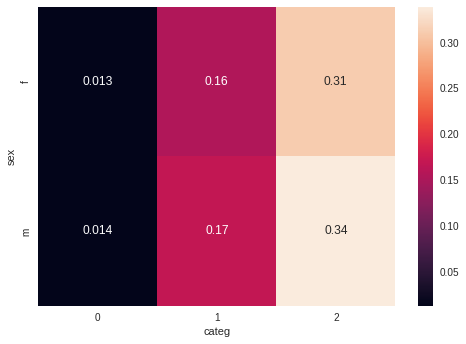

In [141]:
sns.heatmap(table_correlation, annot=True)

## <center> Conclusion </center>
---
<center> On voit que le sexe n'a pas d'influence sur l'achat d'une catégorie de produit.</center>

---

## 2. Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen (en nombre d’articles) ?

In [142]:
clients_lambda['date_exacte'] =pd.to_datetime(clients_lambda['date'].dt.date)
tab=clients_lambda.groupby(['client_id','date_exacte','age'])['qte_prod'].agg('sum').reset_index()
tab=tab.groupby(['client_id','age'])['qte_prod'].agg('mean').reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [143]:
tab[tab.qte_prod > 5]

,client_id,age,qte_prod
1095,c_2166,58,6.000000
1349,c_2433,25,5.500000
1779,c_2888,18,7.000000
2015,c_3136,38,6.000000
5692,c_7034,20,5.333333
6205,c_7583,38,5.500000
6713,c_8127,34,5.666667


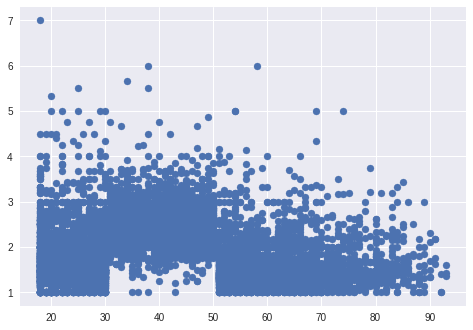

In [144]:
plt.scatter(tab.age, tab.qte_prod)

On remarque deux corrélation:
- Une corrélation positive pour la tranche d'âge 18-42
- Une corrélationn négative pour la tranche d'âge 43-93

In [145]:
bins=[17,25,30,40,42,50,60,70,93]
names=["18-25","25-30","30-40","40-42","42-50","50-60","60-70","70-93"]
tab['tranche_age']=pd.cut(tab.age, bins, labels=names)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


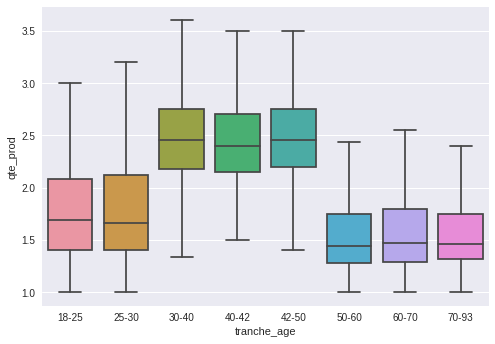

In [146]:
sns.boxplot(tab['tranche_age'], tab['qte_prod'], showfliers=False)
plt.show()

Coefficient de corrélation de pearson

In [147]:
bins=[17,42,93]
names=["18-25","42-93"]
tab['tranche_age']=pd.cut(tab.age, bins, labels=names)

In [148]:
st.pearsonr(tab.age, tab.qte_prod)[0]

-0.1983798180144836

## <center> Conclusion
---
Goblalement l'âge des clients est négativement corrélé au nombre total d'achat. Mais si on scinde les clients en deux groupes: 18-42 ans et 43-93 ans . On voit que l'âge du premier groupe est positivement corrélé au nombre total d'achat, par contre l'âge du deuxième groupe est négativement (très fortement) corrélé au nombre total d'achat.

---

## 3. Y a-t-il une corrélation entre l'âge des clients et le montant total des achats ?

In [149]:
tab=clients_lambda.groupby(['client_id','age'])['price'].agg('sum').reset_index()

- Classification des clients par tranche d'âge

In [150]:
bins=[17,25,30,40,50,60,70,93]
names=["18-25","25-30","30-40","40-50","50-60","60-70","70-93"]
tab['tranche_age']=pd.cut(tab.age ,bins, labels=names)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


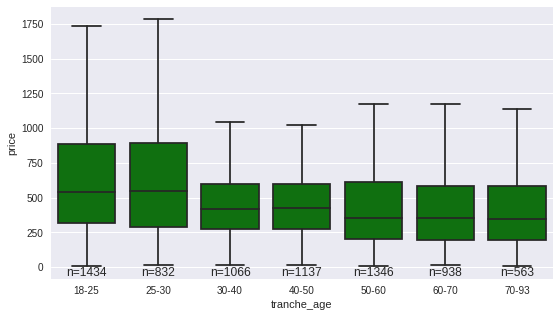

In [151]:
plt.figure(figsize=(9,5))
sns.boxplot(tab['tranche_age'], tab['price'],color="green",showfliers=False)
text =["n=1434","n=832","n=1066","n=1137","n=1346","n=938","n=563"]
for index,valeur in enumerate(text): 
  plt.text(index,0,valeur, horizontalalignment='center',verticalalignment='top')
plt.show()

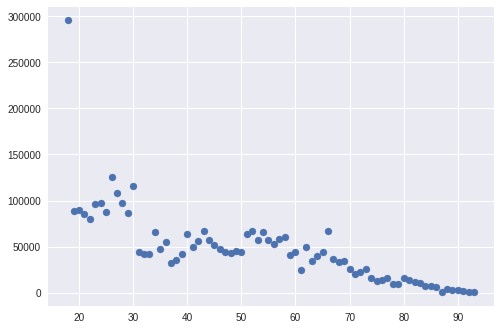

In [152]:
plt.scatter(clients_lambda.groupby('age').sum().index,clients_lambda.groupby('age').sum().price)

In [153]:
st.pearsonr(clients_lambda.groupby('age').sum().index,clients_lambda.groupby('age').sum().price)[0]

-0.7568096119628691

## <center> Conclusion </center>
---
Il y a une corrélation négative entre l'âge et le montant total des achats

---


## 4. Y a-t-il une corrélation entre l'âge des clients et la fréquence d’achat (ie. nombre d'achats par mois par exemple) ?

In [154]:
tab=clients_lambda.set_index(clients_lambda.date.dt.date)

In [155]:
c_t=tab[['client_id','age','qte_prod','nb_total_prod_cm']].sort_values(by='client_id')
c_t['freq_achat']=c_t['nb_total_prod_cm']/11

In [156]:
ct=c_t.groupby('client_id').first().reset_index()
ct=ct.groupby('age').mean().reset_index()

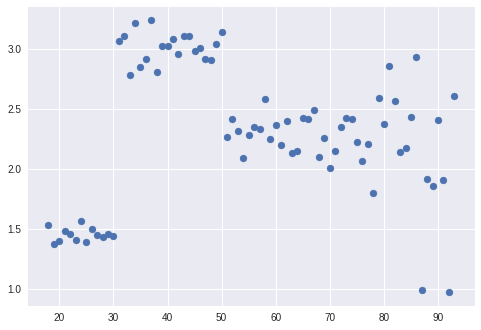

In [157]:
plt.scatter(ct.age,ct.freq_achat)

In [158]:
st.pearsonr(ct.age,ct.freq_achat)[0]

0.04308025279947829

## <center> Conclusion
---
<center> Il n'y a pas de corrélation 

---

## 5. Y a-t-il une corrélation entre l'âge des clients et les catégories de produits achetés ?

Text(2, 17, 'n = 15466')

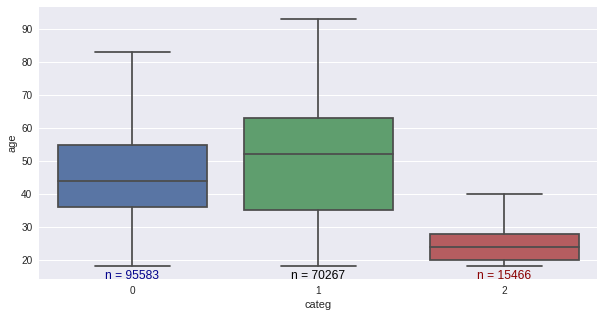

In [159]:
plt.figure(figsize=(10,5))
sns.boxplot(x='categ', y='age', data=clients_lambda[['client_id','age','categ']], showfliers=False)
plt.text(0,17,"n = 95583", horizontalalignment='center',verticalalignment='top', color='darkblue')
plt.text(1,17,"n = 70267", horizontalalignment='center',verticalalignment='top', color='black')
plt.text(2,17,"n = 15466", horizontalalignment='center',verticalalignment='top',color='darkred')


- Les clients qui commandent les produits de catégorie 1 sont globalement plus agés, suivi respectivement par les clients qui commandent la catégorie 0 et 2. 

- D'après ce graphique on peut dors et déjà dire qu'il n'y a pas de correlation entre l'âge du client et la catégorie de produits achetés. 

Nous faire une **TEST ANOVA** avant de faire une conclusion finale

Calcul de la variance interclasse : $SCE = \sum_{i=1}^{k} n_i (\bar y_{i} -\bar y)^2$

In [160]:
y=clients_lambda.age.mean()
yi=clients_lambda.groupby('categ').mean().age
ni=clients_lambda.groupby('categ').size()
SCE= sum(ni*(yi-y)**2)
print(SCE)

7580329.957571795


 Calcul de la variance totale :  $SCT = \sum_{i=1}^{k} \sum_{j=1}^{n_i} (y_{ij} -\bar y)^2$

In [161]:
y=clients_lambda.age.mean()
y0j=clients_lambda[clients_lambda.categ==0].age
y1j=clients_lambda[clients_lambda.categ==1].age
y2j=clients_lambda[clients_lambda.categ==2].age

SCT=sum((y0j-y)**2)+ sum((y1j-y)**2) +sum((y2j-y)**2)

print(SCT)

50385113.84276432


calcul du rapport de corrélation $η^2 = \frac{SCE}{SCT}$

In [162]:
print(SCE/SCT)

0.1504478084782652


# <center> Conclusion 
---
Il n'y a pas de corrélation entre l'âge des clients et les catégories de produits achetés 

---



# <ins>MESURE DE CONCENTRATION : COURBE DE LORENZ, METHODE 1

##Code

In [163]:
base_données

,client_id,sex,birth,id_prod,date,session_id,price,categ,age,qte_prod,nb_total_prod_cm,date_jma
0,c_4410,f,1967,0_1455,2021-03-22 14:29:25.189266,s_9942,8.99,0,55,1,36,2021-03-22
1,c_4410,f,1967,0_1376,2021-09-24 22:58:27.418343,s_94984,16.24,0,55,1,36,2021-09-24
2,c_4410,f,1967,1_312,2022-01-29 14:07:47.482092,s_156960,24.56,1,55,1,36,2022-01-29
3,c_4410,f,1967,1_653,2021-07-29 23:34:41.866951,s_68860,25.99,1,55,1,36,2021-07-29
4,c_4410,f,1967,0_1110,2021-11-04 16:28:30.169021,s_114715,4.71,0,55,1,36,2021-11-04
...,...,...,...,...,...,...,...,...,...,...,...,...
336708,c_1675,f,2000,0_2134,2021-06-17 13:03:04.694904,s_49879,5.57,0,22,1,1,2021-06-17
336709,c_1232,f,1960,0_142,2021-09-25 18:07:25.880052,s_95415,19.85,0,62,1,1,2021-09-25
336710,c_4391,f,2001,2_147,2021-07-23 07:01:38.963669,s_65994,181.99,2,21,1,1,2021-07-23
336711,c_4540,m,2003,2_147,2021-12-05 00:31:15.530765,s_129519,181.99,2,19,1,1,2021-12-05


In [164]:
tmp=base_données[['client_id','qte_prod']].groupby(by=['client_id']).sum()

In [165]:
tmp.index=np.arange(len(tmp))

In [166]:
tmp=tmp.sort_values(by='qte_prod')
tmp

,qte_prod
3925,1
4044,1
694,1
7918,1
1556,1
...,...
7715,195
4388,2562
2724,3273
6337,4471


In [167]:
tmp.index=np.arange(len(tmp))

In [168]:
tmp[861:2*860].sum()

qte_prod    8211
dtype: int64

In [169]:
N = 860
distribution_achat_produit=tmp.groupby(tmp.index // N).sum()
distribution_achat_produit

,qte_prod
0,4003
1,8218
2,11864
3,15401
4,19461
5,24324
6,30725
7,40830
8,58008
9,123879


In [170]:
distribution_achat_produit=pd.DataFrame(distribution_achat_produit)

In [171]:
distribution_achat_produit

,qte_prod
0,4003
1,8218
2,11864
3,15401
4,19461
5,24324
6,30725
7,40830
8,58008
9,123879


In [172]:
distribution_achat_produit=distribution_achat_produit.sort_values(by=["qte_prod"])
distribution_achat_produit

,qte_prod
0,4003
1,8218
2,11864
3,15401
4,19461
5,24324
6,30725
7,40830
8,58008
9,123879


In [173]:
distribution_achat_produit['proportion_qte_prod'] =distribution_achat_produit['qte_prod']/distribution_achat_produit.qte_prod.sum()

In [174]:
distribution_achat_produit['proportion_population'] =0.1

In [175]:
distribution_achat_produit

,qte_prod,proportion_qte_prod,proportion_population
0,4003,0.011888,0.1
1,8218,0.024407,0.1
2,11864,0.035235,0.1
3,15401,0.045739,0.1
4,19461,0.057797,0.1
5,24324,0.072240,0.1
6,30725,0.091250,0.1
7,40830,0.121261,0.1
8,58008,0.172277,0.1
9,123879,0.367907,0.1


In [176]:
distribution_achat_produit['proportion_qte_prod_CC']=distribution_achat_produit['proportion_qte_prod'].cumsum()

In [177]:
distribution_achat_produit['proportion_population_CC']=distribution_achat_produit['proportion_population'].cumsum()

##Résultat

In [178]:
distribution_achat_produit

,qte_prod,proportion_qte_prod,proportion_population,proportion_qte_prod_CC,proportion_population_CC
0,4003,0.011888,0.1,0.011888,0.1
1,8218,0.024407,0.1,0.036295,0.2
2,11864,0.035235,0.1,0.071530,0.3
3,15401,0.045739,0.1,0.117269,0.4
4,19461,0.057797,0.1,0.175066,0.5
5,24324,0.072240,0.1,0.247306,0.6
6,30725,0.091250,0.1,0.338555,0.7
7,40830,0.121261,0.1,0.459816,0.8
8,58008,0.172277,0.1,0.632093,0.9
9,123879,0.367907,0.1,1.000000,1.0


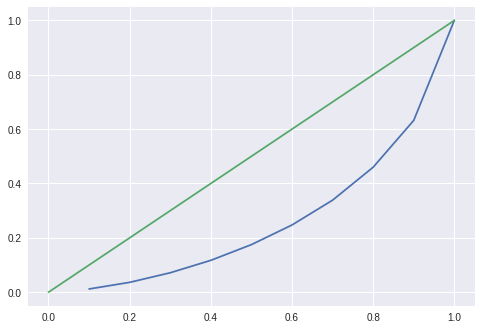

In [179]:
plt.plot(distribution_achat_produit.proportion_population_CC, distribution_achat_produit.proportion_qte_prod_CC)
plt.plot([0,1],[0,1])